## This is a script used for downstream processing of structural variants from HiFi data
This script contains in the first three cells everything needed to convert Severus csv to a vcf to be compatible with other variant callers

In [1]:
# import all needed packages
import glob
import sys
import re
import os
from os import listdir
from os.path import isfile, join
print(sys.executable)
import collections
import math
import pandas as pd
import scipy.sparse as sp
from scipy.sparse import csr_matrix 
import matplotlib
import matplotlib.pyplot as plt
import pycircos
from pycircos.pycircos import Garc
from pycircos.pycircos import Gcircle
import re
from collections import defaultdict
from venn import venn

/software/cellgen/team274/lr26/miniforge3/envs/my-python/bin/python


In [4]:
# set base directory
base_dir = "/lustre/scratch125/cellgen/behjati/lr26/SV/"

In [ ]:
### this part needs to be used before annotating the Severus output with repeats and genes ###
# load the severus output
df = pd.read_csv(base_dir + "PacBio-severus/breakpoints_double.csv", sep=",")

# set up a regex pattern for matching strand, position and chromosome and SVtype and length
pattern = (
    r'([+-])?chr([\dXY]+):(\d+)\|'          # left: strand, chr1, pos1
    r'(?:(?:([+-])?chr([\dXY]+):(\d+))|([A-Z]+):(\d+))'  # right: strand, chr2 & pos2 OR svtype & svlen
)

# extract columns from the csv
df[['strand1', 'chr1', 'pos1',
    'strand2', 'chr2', 'pos2',
    'svtype', 'svlen']] = df.iloc[:, 0].str.extract(pattern)

# and convert numeric to numeric
df[['pos1', 'pos2', 'svlen']] = df[['pos1', 'pos2', 'svlen']].apply(pd.to_numeric, errors='coerce')

# filter for pass in the second column 
df_filtered = df[df.iloc[:, 1] == 'PASS']

# see how it looks
print(df_filtered)

# add the vcf header (here I used the sawfish one but it really doesn't matter much as long as chr lengths are in check and all into is covered)
vcf_header = [
    "##fileformat=VCFv4.2",
    "##ALT=<ID=DEL,Description=\"Deletion\">",
    "##ALT=<ID=BND,Description=\"Breakend\">",
    "##INFO=<ID=SVTYPE,Number=1,Type=String,Description=\"Type of structural variant\">",
    "##INFO=<ID=END,Number=1,Type=Integer,Description=\"End position of the variant\">",
    "##INFO=<ID=SVLEN,Number=1,Type=Integer,Description=\"Length of the structural variant\">",
    "##contig=<ID=chr1,length=248387328>",
    "##contig=<ID=chr2,length=242696752>",
    "##contig=<ID=chr3,length=201105948>",
    "##contig=<ID=chr4,length=193574945>",
    "##contig=<ID=chr5,length=182045439>",
    "##contig=<ID=chr6,length=172126628>",
    "##contig=<ID=chr7,length=160567428>",
    "##contig=<ID=chr8,length=146259331>",
    "##contig=<ID=chr9,length=150617247>",
    "##contig=<ID=chr10,length=134758134>",
    "##contig=<ID=chr11,length=135127769>",
    "##contig=<ID=chr12,length=133324548>",
    "##contig=<ID=chr13,length=113566686>",
    "##contig=<ID=chr14,length=101161492>",
    "##contig=<ID=chr15,length=99753195>",
    "##contig=<ID=chr16,length=96330374>",
    "##contig=<ID=chr17,length=84276897>",
    "##contig=<ID=chr18,length=80542538>",
    "##contig=<ID=chr19,length=61707364>",
    "##contig=<ID=chr20,length=66210255>",
    "##contig=<ID=chr21,length=45090682>",
    "##contig=<ID=chr22,length=51324926>",
    "##contig=<ID=chrX,length=154259566>",
    "##contig=<ID=chrY,length=62460029>",
    "##contig=<ID=chrM,length=16569>",
    "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO"
]

# initialise the vcfrows
vcf_rows = []
# iterate through the csv and add all the info accordingly 
for i, row in df_filtered.iterrows():
    chrom1 = f"chr{row['chr1']}"
    pos1 = int(row['pos1'])
    chrom2 = f"chr{row['chr2']}" if pd.notna(row['chr2']) else chrom1
    pos2 = int(row['pos2']) if pd.notna(row['pos2']) else pos1
    svtype = row['svtype'] if pd.notna(row['svtype']) else 'BND'
    svlen = int(row['svlen']) if pd.notna(row['svlen']) else abs(pos2 - pos1)
    
    # if it is rearrangements then I would like to have the formating comparable to the others
    if svtype != 'BND':
        alt = f"<{svtype}>"
        info = f"END={pos2};SVTYPE={svtype};SVLEN={svlen}"
    else:
        # BND format — example: N]chr2:pos2], often times the [] are variable but I only care 
        # about the positions and chromosomes for the alt
        alt = f"N]{chrom2}:{pos2}]"
        info = f"SVTYPE=BND"
    # append to the rows
    vcf_row = f"{chrom1}\t{pos1}\t.\tN\t{alt}\t.\tPASS\t{info}"
    vcf_rows.append(vcf_row)
    
# put into a vcf file
with open(base_dir + "severus_somatic_breakpoints_double.vcf", "w") as f:
    f.write("\n".join(vcf_header + vcf_rows))

In [3]:
### this is the actual downstream processing of all the somatic input files
## check the vcfs beforehand for the structure
### assumes all the vcfs have been decompressed

# structure of nanomon vcf
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	TUMOR	CONTROL
nanomon_file = base_dir + "PacBio-nanomonsv/tumor-all.nanomonsv.result.annotated.repeats.vcf"
col_names_n = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", 
             "FORMAT", "TUMOR", "CONTROL"]
nanomon = pd.read_csv(nanomon_file, comment='#', sep="\t", names=col_names_n) 

# structure of sawfish vcfs 
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	UnnamedSample
saw_som_file = base_dir + "PacBio-sawfish/sawfish-somatic.annotated.repeats.vcf"
col_names_saw_s = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", 
             "FORMAT", "TUMOR"]
sawfish = pd.read_csv(saw_som_file, comment='#', sep="\t", names=col_names_saw_s) 

# strucutre of severus vcfs
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO
sev = base_dir + "PacBio-severus/severus_somatic_breakpoints_double.annotated.repeats.vcf"
col_names_sev_s = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]
severus = pd.read_csv(sev, comment='#', sep="\t", names=col_names_sev_s) 

# strucutre of savana vcfs
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO FORMAT Sample
sav = base_dir + "PacBio-savana/savana.somatic.annotated.repeats.vcf"
col_sav =  ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", 
               "FORMAT", "tumor_all_4_hifi_reads_pbmm2"]
savana = pd.read_csv(sav, comment='#', sep="\t", names=col_sav)



In [ ]:
# display each
nanomon

In [ ]:
# display each
severus

In [ ]:
# display each
sawfish

In [ ]:
# display each
savana

In [4]:
# do some filtering for passing varinats and to remove chromosome not in patient
nanomon_filtered = nanomon[
    (nanomon["FILTER"] == "PASS")] &
    (~nanomon["#CHROM"].isin(["chrY"]))
]

sawfish_filtered = sawfish[
    (sawfish["FILTER"] == "PASS") &
    (~sawfish["#CHROM"].isin(["chrY"]))
]
severus_filtered = severus[
    (severus["FILTER"] == "PASS") &
    (~severus["#CHROM"].isin(["chrY"]))
]
savana_filtered = savana[
    (savana["FILTER"] == "PASS") &
    (~savana["#CHROM"].isin(["chrY"]))
]

In [5]:
# here extract the different variant types present in each caller
def extract_svtypes(df):
    # Use regex to extract SVTYPE from each INFO string
    svtypes = df["INFO"].str.extract(r"SVTYPE=([^;]+)")
    return svtypes[0].value_counts()
# how many variants of each are where
svtype_nanomon = extract_svtypes(nanomon_filtered)
print(svtype_nanomon)

svtype_saw = extract_svtypes(sawfish_filtered)
print(svtype_saw)

svtype_sav = extract_svtypes(savana_filtered)
print(svtype_sav)

svtype_sev = extract_svtypes(severus_filtered)
print(svtype_sev)


0
BND    112
INS     84
DEL     26
DUP      8
Name: count, dtype: int64
0
DEL    4374
INS    3476
BND     504
DUP     139
INV      11
Name: count, dtype: int64
0
BND     2061
INS      653
SBND      36
Name: count, dtype: int64
0
BND    25843
INS    20086
Name: count, dtype: int64


In [6]:
# here I filter the variants by type and save all of this in separate csv files
def filter_by_svtype(df, svtype):
    return df[df["INFO"].str.contains(f"SVTYPE={svtype}", na=False)]

nanomon_del = filter_by_svtype(nanomon_filtered, "DEL")
nanomon_ins = filter_by_svtype(nanomon_filtered, "INS")
nanomon_bnd = filter_by_svtype(nanomon_filtered, "BND")
nanomon_dup = filter_by_svtype(nanomon_filtered, "DUP")

sawfish_del = filter_by_svtype(sawfish_filtered, "DEL")
sawfish_ins = filter_by_svtype(sawfish_filtered, "INS")
sawfish_bnd = filter_by_svtype(sawfish_filtered, "BND")
sawfish_dup = filter_by_svtype(sawfish_filtered, "DUP")
sawfish_inv = filter_by_svtype(sawfish_filtered, "INV")

severus_ins = filter_by_svtype(severus_filtered, "INS")
severus_bnd = filter_by_svtype(severus_filtered, "BND")

savana_ins = filter_by_svtype(savana_filtered, "INS")
savana_bnd = filter_by_svtype(savana_filtered, "BND")
savana_sbnd = filter_by_svtype(savana_filtered, "SBND")

In [20]:
# save everything to csv files
savana_sbnd.to_csv(base_dir + "savana_somatic_sbnd_genes.csv", sep=",", index=False)
savana_bnd.to_csv(base_dir + "savana_somatic_bnd_genes.csv", sep=",", index=False)
savana_ins.to_csv(base_dir + "savana_somatic_ins_genes.csv", sep=",", index=False)
severus_ins.to_csv(base_dir + "severus_somatic_ins_genes.csv", sep=",", index=False)
severus_bnd.to_csv(base_dir + "severus_somatic_bnd_genes.csv", sep=",", index=False)
sawfish_inv.to_csv(base_dir + "sawfish_somatic_inv_genes.csv", sep=",", index=False)
sawfish_del.to_csv(base_dir + "sawfish_somatic_del_genes.csv", sep=",", index=False)
sawfish_dup.to_csv(base_dir + "sawfish_somatic_duplication_genes.csv", sep=",", index=False)
sawfish_ins.to_csv(base_dir + "sawfish_somatic_ins_genes.csv", sep=",", index=False)
sawfish_bnd.to_csv(base_dir + "sawfish_somatic_bnd_genes.csv", sep=",", index=False)
nanomon_dup.to_csv(base_dir + "nanomonsv_somatic_dup_genes.csv", sep=",", index=False)
nanomon_del.to_csv(base_dir + "nanomonsv_somatic_del_genes.csv", sep=",", index=False)
nanomon_bnd.to_csv(base_dir + "nanomonsv_somatic_bnd_genes.csv", sep=",", index=False)
nanomon_ins.to_csv(base_dir + "nanomonsv_somatic_ins_genes.csv", sep=",", index=False)

In [21]:
## venn diagrams, I have added a buffer of 5
def get_variant_ids_with_buffer(df, buffer=5):
    """makes unique variant ids based on chromosome and buffered range"""
    return set(
        df["#CHROM"].astype(str) + ":" + 
        (df["POS"].astype(int) - buffer).astype(str) + "-" + 
        (df["POS"].astype(int) + buffer).astype(str)
    )
# function to do venn with the svtype, input dfs, label suffix and buffer
def venn_svtype_with_buffer(svtype,
                             nanomon_df=None,
                             sawfish_df=None,
                             severus_df=None,
                             savana_df=None,
                             label_suffix="somatic",
                             buffer=5):

    """
    I am using the venn packages to plot a particular sv variant type for all the callers
    """
    def filter_by_svtype(df):
        return df[df["INFO"].str.contains(f"SVTYPE={svtype}", na=False)]
    # the venn package uses dictionaries
    venn_dict = {}
    # put colors and buffers and ids for variants for each of the caller if present
    if nanomon_df is not None:
        ids = get_variant_ids_with_buffer(filter_by_svtype(nanomon_df), buffer)
        venn_dict["Nanomonsv"] = ids

    if sawfish_df is not None:
        ids = get_variant_ids_with_buffer(filter_by_svtype(sawfish_df), buffer)
        venn_dict["Sawfish"] = ids

    if severus_df is not None:
        ids = get_variant_ids_with_buffer(filter_by_svtype(severus_df), buffer)
        venn_dict["Severus"] = ids

    if savana_df is not None:
        ids = get_variant_ids_with_buffer(filter_by_svtype(savana_df), buffer)
        venn_dict["Savana"] = ids
        
    # I am setting it up so that at least 2 are needed for the venn diagram
    if len(venn_dict) < 2:
        print("Need at least two datasets to generate a Venn diagram.")
        return

    venn(venn_dict)
    # plot title and showing
    plt.title(f"{svtype} Overlap ({label_suffix}) with ±{buffer}bp Buffer")
    plt.show()
 


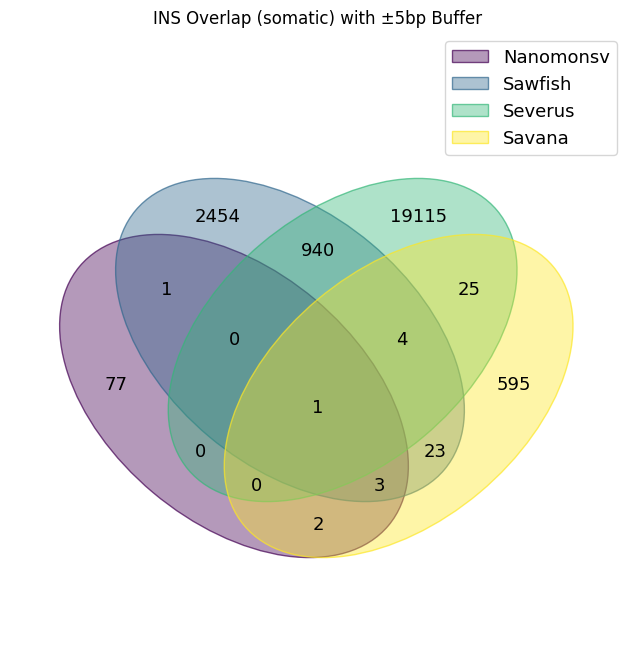

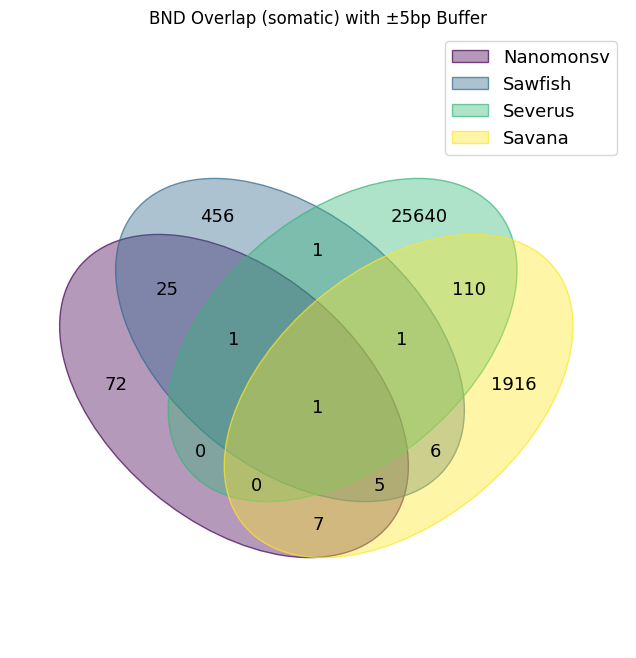

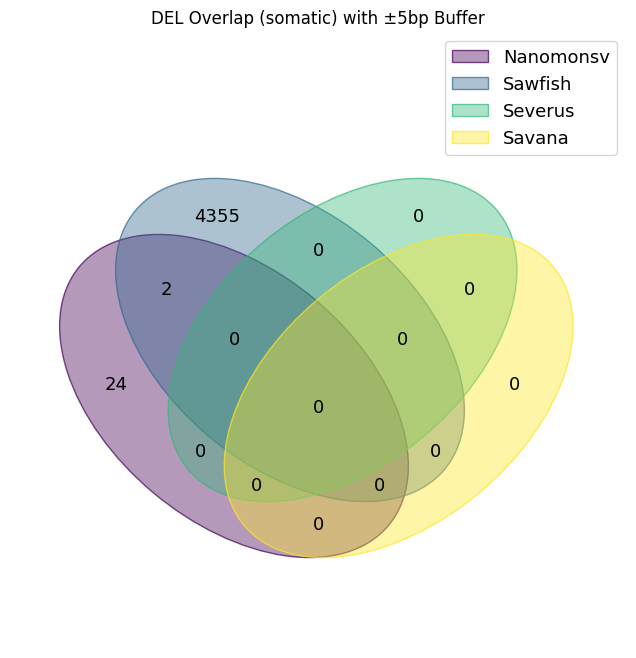

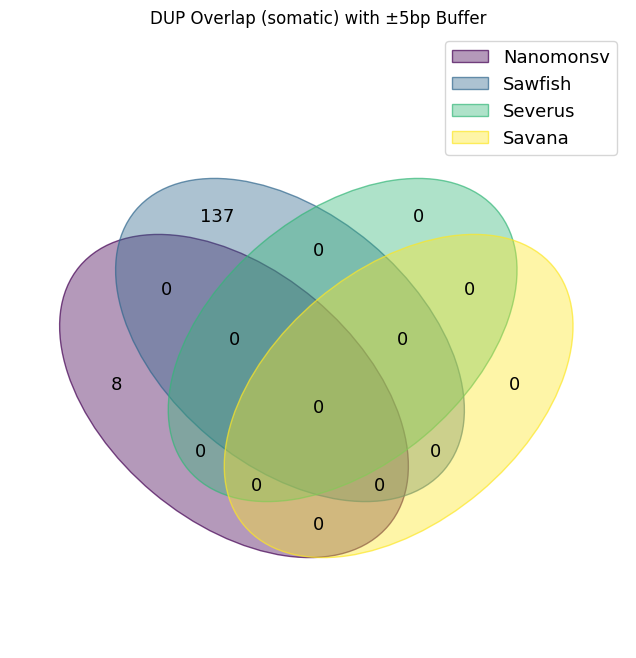

In [22]:
# using the function to plot the different variants
venn_svtype_with_buffer("INS", nanomon_df=nanomon_filtered, sawfish_df=sawfish_filtered, 
                        severus_df=severus_filtered, savana_df=savana_filtered, 
                        label_suffix="somatic", buffer=5)
venn_svtype_with_buffer("BND", nanomon_df=nanomon_filtered, sawfish_df=sawfish_filtered, 
                        severus_df=severus_filtered, savana_df=savana_filtered,
                        label_suffix="somatic", buffer=5)
venn_svtype_with_buffer("DEL", nanomon_df=nanomon_filtered, sawfish_df=sawfish_filtered, 
                        severus_df=severus_filtered, savana_df=savana_filtered, 
                        label_suffix="somatic", buffer=5)
venn_svtype_with_buffer("DUP", nanomon_df=nanomon_filtered, sawfish_df=sawfish_filtered, 
                        severus_df=severus_filtered, savana_df=savana_filtered,
                        label_suffix="somatic", buffer=5)

In [24]:
### this is a script which enabled synamic +/-5 bp windown on both chromosomes
# involved in the breakpoint of structural rearrangement variants
### this function extracts the raw bnd breakpoint pairs using the already known regex of how nds are given 
def extract_bnd_pair(row):
    chrom1, pos1, alt = row["#CHROM"], int(row["POS"]), row["ALT"]
    match = re.search(r'[\[\]](.*?):(\d+)[\[\]]', alt)
    if not match:
        return None
    return ((chrom1, pos1), (match.group(1), int(match.group(2)))) # returns a touple

# this function bins the bnd pairs using a bin size of 10
def get_bnd_pairs_binned(df, svtype="BND", bin_size=10):
    filtered = df[df["INFO"].str.contains(f"SVTYPE={svtype}", na=False)].copy()
    
    # using a list comprehension to get the filtered bnd pair
    filtered["_bnd_pair"] = [extract_bnd_pair(row) for row in filtered.to_dict(orient="records")]
    filtered = filtered[filtered["_bnd_pair"].notnull()]
    
    # build a bnd index mapping bin locations to their associated pairs for fast lookup
    binned_index = defaultdict(list)
    for idx, bnd in enumerate(filtered["_bnd_pair"]):
        (c1, p1), (c2, p2) = bnd
        bin1 = p1 // bin_size
        bin2 = p2 // bin_size
        # store index and pair for quick lookup
        binned_index[(c1, bin1)].append((idx, bnd))
        binned_index[(c2, bin2)].append((idx, bnd))
    
    return filtered, binned_index

# checks whether two bnds are close enough for an overlap
# compares both sides of the breakend and if they are within buffer on the same chromosome
# they are considered to overlap, the function also supports if the order is flipped
def bnd_pair_overlaps(bnd1, bnd2, buffer=5):
    def overlap(a_chr, a_pos, b_chr, b_pos):
        return a_chr == b_chr and abs(a_pos - b_pos) <= buffer

    (a1, a2), (b1, b2) = bnd1, bnd2
    return (overlap(*a1, *b1) and overlap(*a2, *b2)) or (overlap(*a1, *b2) and overlap(*a2, *b1))

# here I am putting in the four df
# this function:
# looks in same or neighboring bins for potential matches across all other callers
# checks for actual overlap with the bnd pair overlaps function
# builds a cluster of overlap pairs
def find_shared_bnd_pairs_binned(nanomon_df, sawfish_df, severus_df, savana_df, buffer=5, min_overlap=2, bin_size=10):
    name_to_df = {
        "nanomon": nanomon_df,
        "sawfish": sawfish_df,
        "severus": severus_df,
        "savana": savana_df,
    }

    # for each caller id does filtering and builds a binned index
    data = {}
    for name, df in name_to_df.items():
        filtered, binned_index = get_bnd_pairs_binned(df, bin_size=bin_size)
        data[name] = {"df": filtered, "index": binned_index}

    clusters = []
    used = set()
    # the it creates a combined list of caller, idx, bnd tuples for iteration
    combined = []
    for caller, info in data.items():
        for idx, bnd in enumerate(info["df"]["_bnd_pair"]):
            combined.append((caller, idx, bnd))

    # it iterates over this list
    for i, (caller_i, idx_i, bnd_i) in enumerate(combined):
        if (caller_i, idx_i) in used:
            continue

        cluster = [(caller_i, idx_i, bnd_i)]
        used.add((caller_i, idx_i))

        # Get bins for bnd_i
        (c1_i, p1_i), (c2_i, p2_i) = bnd_i
        bin1_i = p1_i // bin_size
        bin2_i = p2_i // bin_size

        # Look for candidates in same/adjacent bins in both breakpoints
        candidate_pairs = []
        for caller_j, info_j in data.items():
            for bin1 in (bin1_i - 1, bin1_i, bin1_i + 1):
                for bin2 in (bin2_i - 1, bin2_i, bin2_i + 1):
                    candidate_pairs.extend([(caller_j, idx, bnd) for idx, bnd in info_j["index"].get((c1_i, bin1), [])])
                    candidate_pairs.extend([(caller_j, idx, bnd) for idx, bnd in info_j["index"].get((c2_i, bin2), [])])

        # then performs deduplication 
        candidate_pairs = list({(caller, idx): bnd for caller, idx, bnd in candidate_pairs}.items())
        # candidate_pairs is now list of ((caller, idx), bnd)

        for (caller_j, idx_j), bnd_j in candidate_pairs:
            if (caller_j, idx_j) in used:
                continue
            if bnd_pair_overlaps(bnd_i, bnd_j, buffer):
                cluster.append((caller_j, idx_j, bnd_j))
                used.add((caller_j, idx_j))

        clusters.append(cluster)

    # filters clusters by  the minimum overlap across different callers
    kept_clusters = [
        cluster
        for cluster in clusters
        if len(set(caller for caller, _, _ in cluster)) >= min_overlap
    ]

    # extracts matching rows
    matched_rows = []
    for cluster in kept_clusters:
        for caller, idx, bnd in cluster:
            df = data[caller]["df"]
            row = df.iloc[idx].copy()
            row["caller"] = caller
            row["Gene"] = row["INFO"].split("genes=")[-1].split(";")[0] if "genes=" in row["INFO"] else None
            row["Repeat"] = row["INFO"].split("repeats=")[-1].split(";")[0] if "repeats=" in row["INFO"] else None
            matched_rows.append(row.drop("_bnd_pair"))

    return pd.DataFrame(matched_rows).drop_duplicates()

# this is how these functions are used
shared_bnds_df = find_shared_bnd_pairs_binned(
    nanomon_df=nanomon_filtered,
    sawfish_df=sawfish_filtered,
    severus_df=severus_filtered,
    savana_df=savana_filtered,
    buffer=5,
    min_overlap=2,
    bin_size=10
)

# view results
print(shared_bnds_df)


      #CHROM        POS                   ID REF                ALT QUAL  \
1       chr1    8595288                r_0_0   g  [chr14:87478046[A    .   
179    chr14   87478046                r_0_1   A    [chr1:8595288[A    .   
7098   chr14   87478046  sawfish:0:350:0:0:1   A    [chr1:8595288[A  999   
49      chr1    8595284  sawfish:0:350:0:0:0   C  [chr14:87478050[C  999   
2       chr1   66864042                r_3_0   T   [chr1:66864444[A    .   
...      ...        ...                  ...  ..                ...  ...   
2729    chrX  104712167          ID_103588_1   t  [chrX:104721794[t    .   
2730    chrX  104721794          ID_103588_2   C  [chrX:104712167[C    .   
25575   chrX  110869608                    .   N  N]chrX:110869633]    .   
2732    chrX  110869608          ID_103655_1   a  a[chrX:110869632[    .   
2733    chrX  110869632          ID_103655_2   a  ]chrX:110869608]a    .   

      FILTER                                               INFO       FORMAT  \
1      

In [25]:
# save the bnds to a csv
shared_bnds_df.to_csv(base_dir + "bnd_vars_at_least_2_callers_buffer_5_annotated.csv", sep = ",", index=False)

In [ ]:
# this step is to format the bnd variants for the graphing of circos plots
# here I extract the genes and repeats annotations
def extract_annotations(info):
    gene = None
    repeat = None
    if pd.notnull(info):
        if "genes=" in info:
            gene = info.split("gene_name=")[-1].split(";")[0]
        if "repeats=" in info:
            repeat = info.split("repeats=")[-1].split(";")[0]
    return pd.Series([gene, repeat])

shared_bnds_df[['Gene', 'Repeat']] = shared_bnds_df['INFO'].apply(extract_annotations)

# then I parse the alternative allele bnds for chromosome and position using regex
def parse_alt(alt):
    match = re.search(r'[\[\]]?([ACGTN]{0,20}?)?(chr[\wXYM]+):(\d+)[ACGTN]{0,20}?[\[\]]?', str(alt))
    if match:
        return match.group(2), int(match.group(3))  # chromosome, position
    return None, None

# I then apply the parse alt function to create chr2 and start2 columns 
shared_bnds_df[['chr2', 'start2']] = shared_bnds_df['ALT'].dropna().apply(lambda alt: pd.Series(parse_alt(alt)))

# then I make the en1 end2 columns as offsets by 1 nt to be able to input to pycircos
shared_bnds_df['end1'] = shared_bnds_df['POS'] + 1
shared_bnds_df['end2'] = shared_bnds_df['start2'] + 1

# then I rename the chr and pos to chr1 and start1
shared_bnds_df = shared_bnds_df[['#CHROM', 'POS', 'end1', 'chr2', 'start2', 'end2']].rename(
    columns={'#CHROM': 'chr1', 'POS': 'start1'}
)

# and save the full processed dataframe
shared_bnds_df.to_csv(base_dir + "bnd_vars_at_least_2_callers_buffer_5_sanitized_new.csv", sep=",", index=False)

# for plotting purposes I filter to only inter-chromosomal bnds and save the filtered one as well
shared_bnds_df_filtered = shared_bnds_df[shared_bnds_df['chr1'] != shared_bnds_df['chr2']].copy()
shared_bnds_df_filtered.to_csv(base_dir + "bnd_vars_at_least_2_callers_buffer_5_sanitized_new_filtered.csv", sep=",", index=False)


In [ ]:
# here I am using a csv with the chromosome names and coordinates as input to the Gcircle
# that can easily be obtained from any vcf header by reformatiing to a bed-like format
# this code usage comes from the documentation
circle = Gcircle(figsize=(8,8)) 
with open("/nfs/users/nfs_l/lr26/shells/chromosome_data.csv") as f:
    f.readline()
    for line in f:
        line   = line.rstrip().split(",") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(935,985), labelposition=80, label_visible=True)
        circle.add_garc(arc) 
        
circle.set_garcs(-180, 180)  # I am using the full circle

for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20000000, ticklabels=None)
    
# and the filtered bnd variants which I parse
with open(base_dir + "bnd_vars_at_least_2_callers_buffer_5_sanitized_new_filtered.csv") as f:
    next(f)  # Skip header line
    for line in f:
        line = line.rstrip().split(",")
        name1, start1, end1 = line[0], int(line[1]), int(line[2])
        name2, start2, end2 = line[3], int(line[4]), int(line[5])

        # face colors for the arc dictionary
        facecolor1 = circle.garc_dict[name1].facecolor if name1 in circle.garc_dict else "gray"
        facecolor2 = circle.garc_dict[name2].facecolor if name2 in circle.garc_dict else "gray"

        # draw chord
        source = (name1, start1, end1, 900)
        destination = (name2, start2, end2, 900)
        circle.chord_plot(source, destination, facecolor=facecolor1, edgecolor=facecolor1, linewidth=1)
        
# save the figure rightaway
circle.figure.savefig(base_dir + "shared_bnd_at_least_2_sanitied_final_buffer5.pdf", dpi=300, bbox_inches="tight")

In [32]:
# this is a bit of a simpler setup than for bnds (bnds were the main focus given the cancer type)
# this is not very dynamic, does not handle binning for speed and the orientation (and spread across chroms)
def extract_shared_variants_rows(svtype, dfs, buffer=5, min_overlap=2):
    """
    extract rows of variants of a given svtype shared by at least minimum overlap (2) dataframes.
    dfs: dict of {name: dataframe} pairs, meaning {"Nanomonsv": nanomon_df, ...}
    """
    # again filter by each variant type and get the ids with buffer
    filtered_ids = {}
    for name, df in dfs.items():
        filtered = df[df["INFO"].str.contains(f"SVTYPE={svtype}", na=False)]
        filtered_ids[name] = get_variant_ids_with_buffer(filtered, buffer)

    # count occurences of each variant id across 
    from collections import Counter
    id_counter = Counter()
    for s in filtered_ids.values():
        id_counter.update(s)

    # find variant IDs that appear in at least 2 datasets
    shared_ids = {vid for vid, count in id_counter.items() if count >= min_overlap}

    # and extract matching rows from all dfs
    shared_rows_list = []
    for df in dfs.values():
        # to build a buffered variant id from rows in this dataframe
        df["_var_id"] = (
            df["#CHROM"].astype(str) + ":" +
            (df["POS"].astype(int) - buffer).astype(str) + "-" +
            (df["POS"].astype(int) + buffer).astype(str)
        )
        # then select rows whose variant id is in shared_ids and match svtype
        # also extract the genes and repeats annotations
        rows = df[(df["_var_id"].isin(shared_ids)) & (df["INFO"].str.contains(f"SVTYPE={svtype}", na=False))]
        rows["Gene"] = rows["INFO"].apply(lambda x: x.split("genes=")[-1].split(";")[0] if pd.notna(x) and "genes=" in x else None)
        rows["Repeat"] = rows["INFO"].apply(lambda x: x.split("repeats=")[-1].split(";")[0] if pd.notna(x) and "repeats=" in x else None)
        shared_rows_list.append(rows)

    # combine and remove the helper column
    result = pd.concat(shared_rows_list).drop(columns=["_var_id"]).drop_duplicates().reset_index(drop=True)
    return result

In [35]:
# here is the usage of the functions above
dfs = {
    "Nanomonsv": nanomon_filtered,
    "Sawfish": sawfish_filtered,
    "Severus": severus_filtered,
    "Savana": savana_filtered
}

ins_shared_rows = extract_shared_variants_rows("INS", dfs, buffer=5, min_overlap=2)
del_shared_rows = extract_shared_variants_rows("DEL", dfs, buffer=5, min_overlap=2)
dup_shared_rows = extract_shared_variants_rows("DUP", dfs, buffer=5, min_overlap=2)


/tmp/ipykernel_4163868/3843871397.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["_var_id"] = (
/tmp/ipykernel_4163868/3843871397.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows["Gene"] = rows["INFO"].apply(lambda x: x.split("gene_name=")[-1].split(";")[0] if pd.notna(x) and "gene_name=" in x else None)
/tmp/ipykernel_4163868/3843871397.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [36]:
# here I have saved them in csv files 

ins_shared_rows.to_csv(base_dir + "ins_vars_genes_at_least_2_callers_buffer_5.csv", sep = ",", index=False)
del_shared_rows.to_csv(base_dir + "del_vars_genes_at_least_2_callers_buffer_5.csv", sep = ",", index=False)
dup_shared_rows.to_csv(base_dir + "dup_vars_genes_at_least_2_callers_buffer_5.csv", sep = ",", index=False)

In [8]:
### sawfish germline genic filtering - I focused only on the within gene ones

# structure of sawfish vcfs 
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	UnnamedSample
saw_ger_file = base_dir + "PacBio-sawfish/blood_genotyped.annotated.repeats.norm.sv.vcf"
col_names_saw = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", 
             "FORMAT", "TUMOR"]
sawfish_ger = pd.read_csv(saw_ger_file, comment='#', sep="\t", names=col_names_saw) 

In [14]:
sawfish_germline_filtered = sawfish_ger[
    (sawfish_ger["FILTER"] == "PASS") &
    (~sawfish_ger["#CHROM"].isin(["chrY"])) &
    sawfish_ger["INFO"].str.contains("repeats=", na=False)
]

In [18]:
sawfish_germline_filtered.to_csv("/lustre/scratch125/cellgen/behjati/lr26/SV/PacBio-sawfish/sawfish-germline-genes.tsv", sep="\t", index=False)